In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Activation, Dropout ,Conv2D,MaxPool2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report 

2025-08-16 20:22:59.414952: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755375779.586824      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755375779.639163      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Read Data

In [2]:
data_dir='/kaggle/input/gtsrb-german-traffic-sign'
target_folder='train'
filepath=[]
labels=[]
all_folder_path = os.path.join(data_dir, target_folder)

if os.path.isdir(all_folder_path):
    filelist = os.listdir(all_folder_path)
    for f in filelist:
        fpath = os.path.join(all_folder_path, f)
        fipath=os.listdir(fpath)
        for image in fipath:
            path = os.path.join(fpath, image)
            filepath.append(path)
            labels.append(f)  

f_series = pd.Series(filepath, name='filepath')
l_series = pd.Series(labels, name='labels')
train_df = pd.concat([f_series, l_series], axis=1)
train_df

,filepath,labels
0,/kaggle/input/gtsrb-german-traffic-sign/train/...,7
1,/kaggle/input/gtsrb-german-traffic-sign/train/...,7
2,/kaggle/input/gtsrb-german-traffic-sign/train/...,7
3,/kaggle/input/gtsrb-german-traffic-sign/train/...,7
4,/kaggle/input/gtsrb-german-traffic-sign/train/...,7
...,...,...
39204,/kaggle/input/gtsrb-german-traffic-sign/train/...,24
39205,/kaggle/input/gtsrb-german-traffic-sign/train/...,24
39206,/kaggle/input/gtsrb-german-traffic-sign/train/...,24
39207,/kaggle/input/gtsrb-german-traffic-sign/train/...,24


In [3]:
test_df=pd.read_csv('/kaggle/input/gtsrb-german-traffic-sign/Test.csv')
test_df=test_df.iloc[:,6:]
test_df

,ClassId,Path
0,16,Test/00000.png
1,1,Test/00001.png
2,38,Test/00002.png
3,33,Test/00003.png
4,11,Test/00004.png
...,...,...
12625,12,Test/12625.png
12626,33,Test/12626.png
12627,6,Test/12627.png
12628,7,Test/12628.png


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39209 entries, 0 to 39208
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filepath  39209 non-null  object
 1   labels    39209 non-null  object
dtypes: object(2)
memory usage: 612.8+ KB


In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12630 entries, 0 to 12629
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ClassId  12630 non-null  int64 
 1   Path     12630 non-null  object
dtypes: int64(1), object(1)
memory usage: 197.5+ KB


# Visualization

In [6]:
count_train = train_df["labels"].value_counts()
count_train

labels
2     2250
1     2220
13    2160
12    2100
38    2070
10    2010
4     1980
5     1860
25    1500
9     1470
7     1440
3     1410
8     1410
11    1320
18    1200
35    1200
17    1110
31     780
14     780
33     689
15     630
26     600
28     540
23     510
30     450
6      420
16     420
34     420
36     390
22     390
20     360
40     360
21     330
39     300
24     270
29     270
27     240
32     240
42     240
41     240
19     210
0      210
37     210
Name: count, dtype: int64

In [7]:
train_df['labels'].unique()

array(['7', '17', '19', '22', '2', '35', '23', '10', '5', '36', '20',
       '27', '41', '39', '32', '25', '42', '8', '38', '12', '0', '31',
       '34', '18', '28', '16', '13', '26', '15', '3', '1', '30', '14',
       '4', '9', '21', '40', '6', '11', '37', '33', '29', '24'],
      dtype=object)

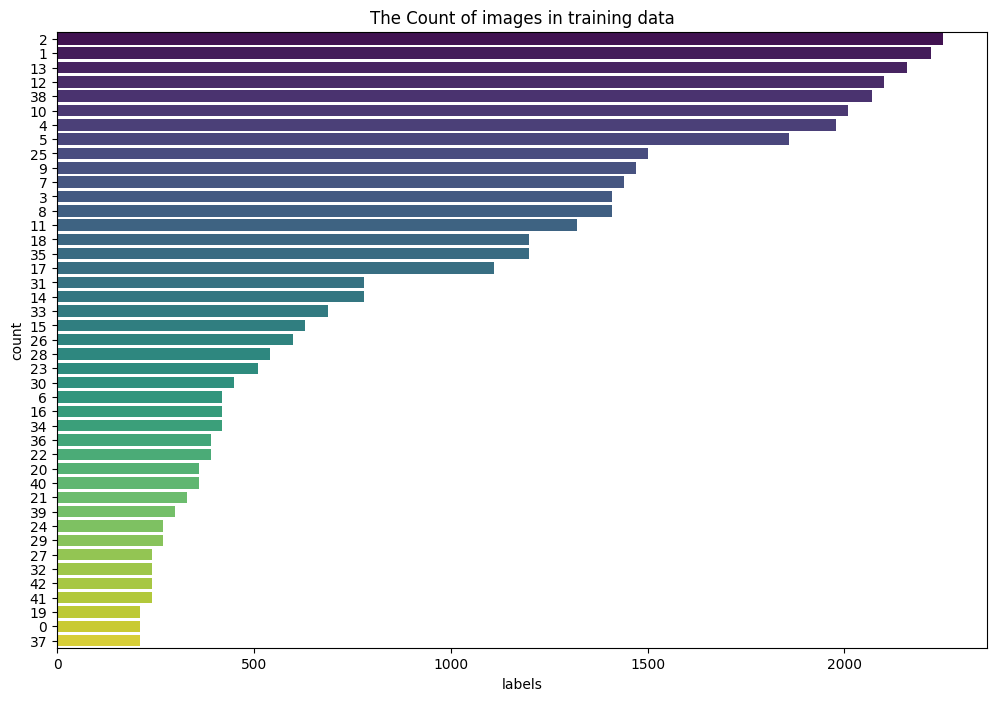

In [8]:
plt.figure(figsize=(12,8))
sns.barplot(x=count_train.values,y=count_train.index,palette='viridis')
plt.title('The Count of images in training data')
plt.xlabel('labels')
plt.ylabel('count')
plt.show()

In [9]:
strat=train_df['labels']
train_df,valid_df=train_test_split(train_df,test_size=0.2,random_state=42,stratify=strat)

# Data Augmentation

In [10]:
batch_size = 16
img_size = (64, 64)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
gen = ImageDataGenerator()

train_gen = gen.flow_from_dataframe(
    train_df,
    x_col= 'filepath',
    y_col= 'labels',
    target_size= img_size,
    class_mode= 'categorical',
    color_mode= 'rgb',
    shuffle= True,
    batch_size= batch_size)

valid_gen = gen.flow_from_dataframe(
    valid_df,
    x_col= 'filepath',
    y_col= 'labels',
    target_size= img_size,
    class_mode= 'categorical',
    color_mode= 'rgb',
    shuffle= True,
    batch_size= batch_size)

Found 31367 validated image filenames belonging to 43 classes.
Found 7842 validated image filenames belonging to 43 classes.


In [11]:
test_df['ClassId'] = test_df['ClassId'].astype(str)
base_dir = '/kaggle/input/gtsrb-german-traffic-sign/'
test_gen = gen.flow_from_dataframe(
    test_df,
    x_col= 'Path',
    y_col= 'ClassId',
    target_size= img_size,
    class_mode= 'categorical',
    color_mode= 'rgb',
    shuffle= False,
    batch_size= batch_size,
    directory=base_dir)

Found 12630 validated image filenames belonging to 43 classes.


# Samples

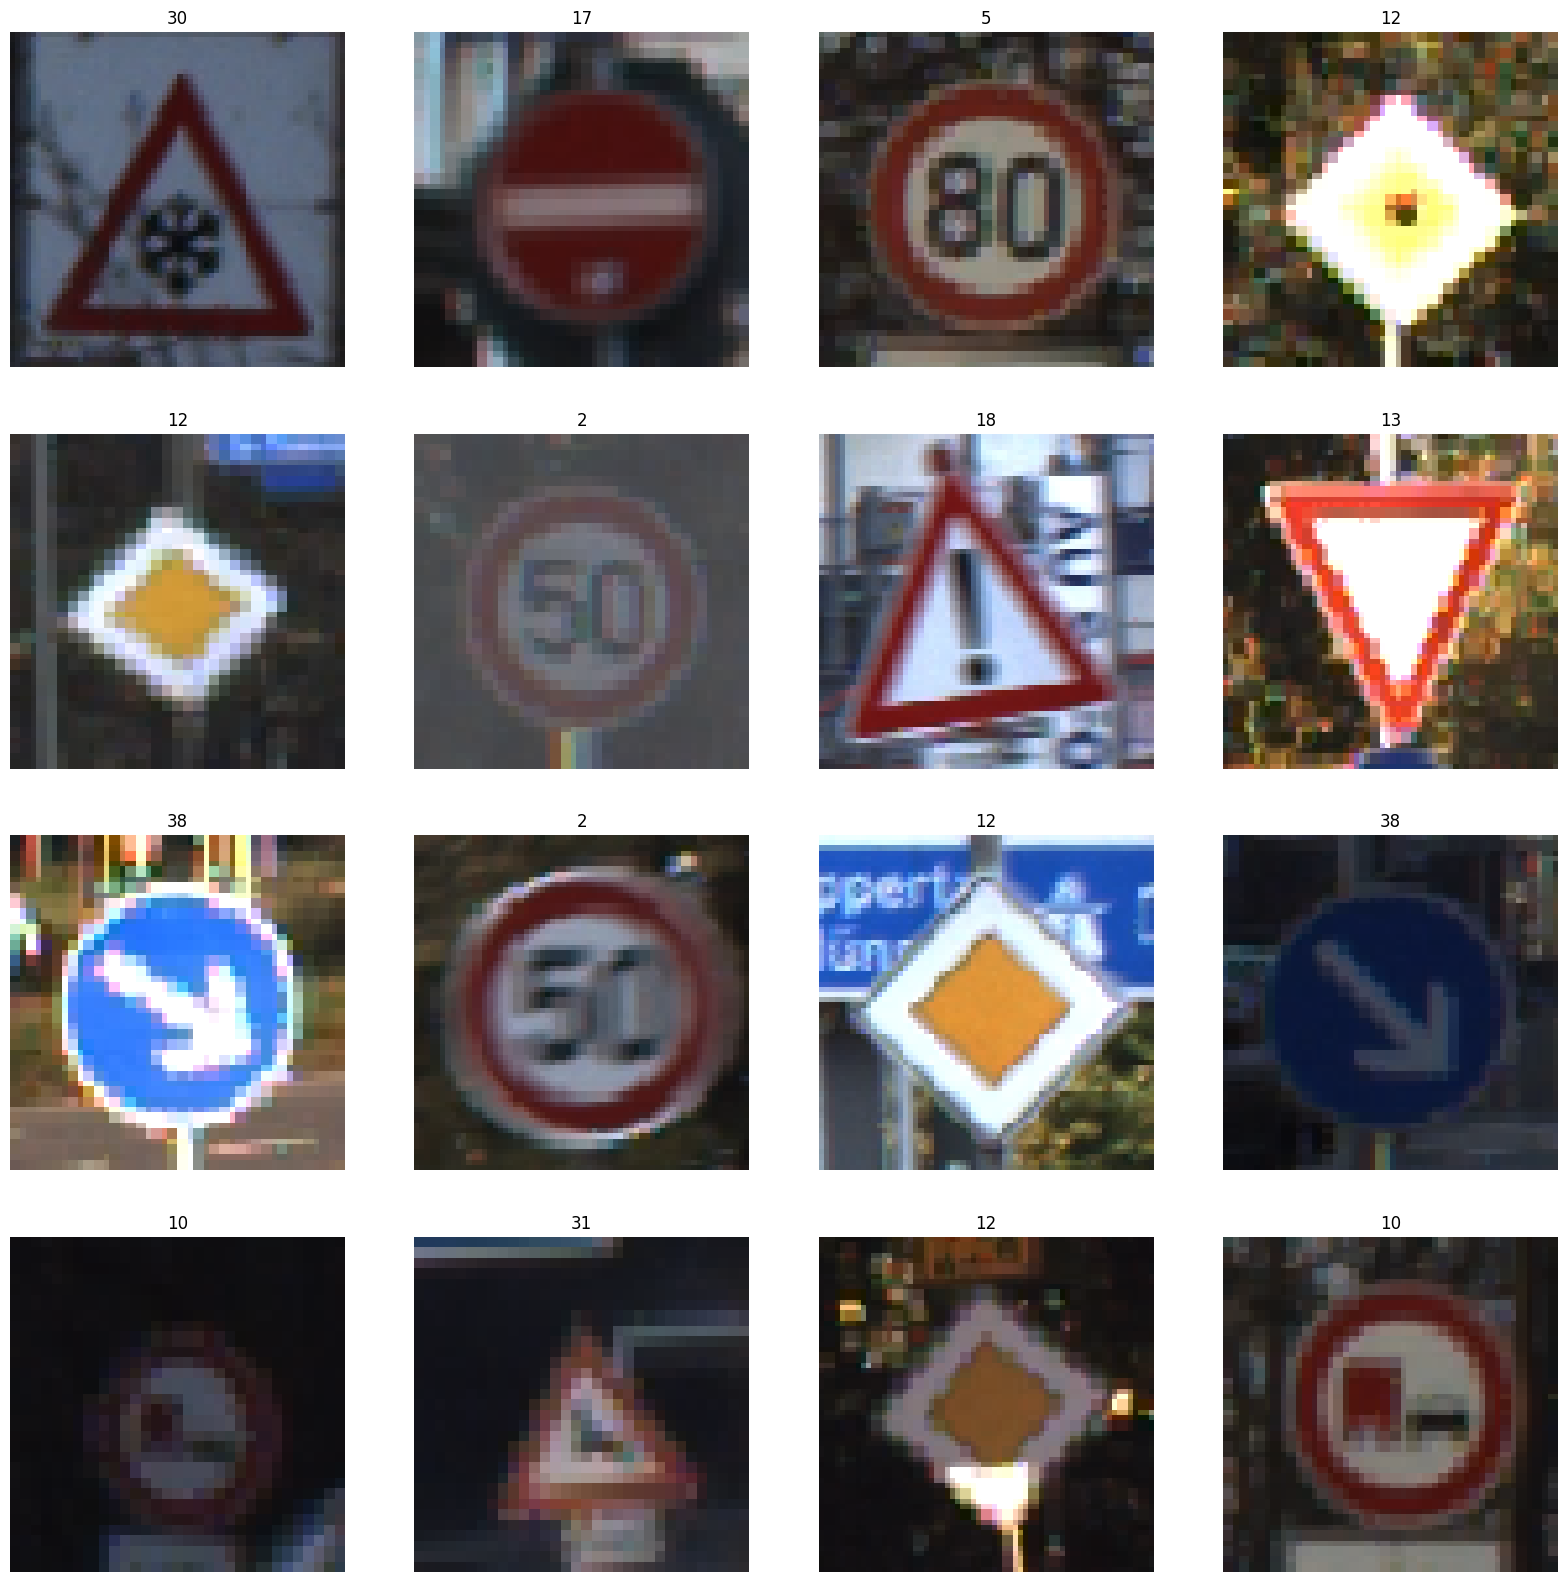

In [12]:
g_dict = train_gen.class_indices    
classes = list(g_dict.keys())      
images, labels = next(train_gen)     

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255      
    plt.imshow(image)
    index = np.argmax(labels[i])  
    class_name = classes[index]   
    plt.title(class_name, color= 'black', fontsize= 12)
    plt.axis('off')
plt.show()

# Model

In [13]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=train_gen.image_shape))
model.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.15))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.20))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(43, activation='softmax'))

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1755375954.531229      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1755375954.531995      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 60, 60, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 56, 56, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        22,059 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,319,659 (73.70 MB)

 Trainable params: 19,319,659 (73.70 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history=model.fit(train_gen, epochs=100, validation_data=valid_gen, shuffle=False, callbacks=[early_stopping], validation_steps= None)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1755375958.634830      65 service.cc:148] XLA service 0x7c1df40076d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755375958.635596      65 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1755375958.635618      65 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1755375958.940935      65 cuda_dnn.cc:529] Loaded cuDNN version 90300


   3/1961 ━━━━━━━━━━━━━━━━━━━━ 1:55 59ms/step - accuracy: 0.0243 - loss: 81.3422     

I0000 00:00:1755375963.494413      65 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1961/1961 ━━━━━━━━━━━━━━━━━━━━ 260s 129ms/step - accuracy: 0.6517 - loss: 2.7293 - val_accuracy: 0.9740 - val_loss: 0.1163
Epoch 2/100
1961/1961 ━━━━━━━━━━━━━━━━━━━━ 48s 24ms/step - accuracy: 0.9736 - loss: 0.1123 - val_accuracy: 0.9892 - val_loss: 0.0564
Epoch 3/100
1961/1961 ━━━━━━━━━━━━━━━━━━━━ 46s 24ms/step - accuracy: 0.9869 - loss: 0.0525 - val_accuracy: 0.9922 - val_loss: 0.0302
Epoch 4/100
1961/1961 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.9919 - loss: 0.0319 - val_accuracy: 0.9938 - val_loss: 0.0316
Epoch 5/100
1961/1961 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.9939 - loss: 0.0220 - val_accuracy: 0.9936 - val_loss: 0.0359
Epoch 6/100
1961/1961 ━━━━━━━━━━━━━━━━━━━━ 40s 20ms/step - accuracy: 0.9954 - loss: 0.0192 - val_accuracy: 0.9944 - val_loss: 0.0358
Epoch 7/100
1961/1961 ━━━━━━━━━━━━━━━━━━━━ 39s 20ms/step - accuracy: 0.9972 - loss: 0.0098 - val_accuracy: 0.9954 - val_loss: 0.0325
Epoch 8/100
1961/1961 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.9973 - l

# Plot

In [16]:
def plot(history=None):
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout
    plt.show()

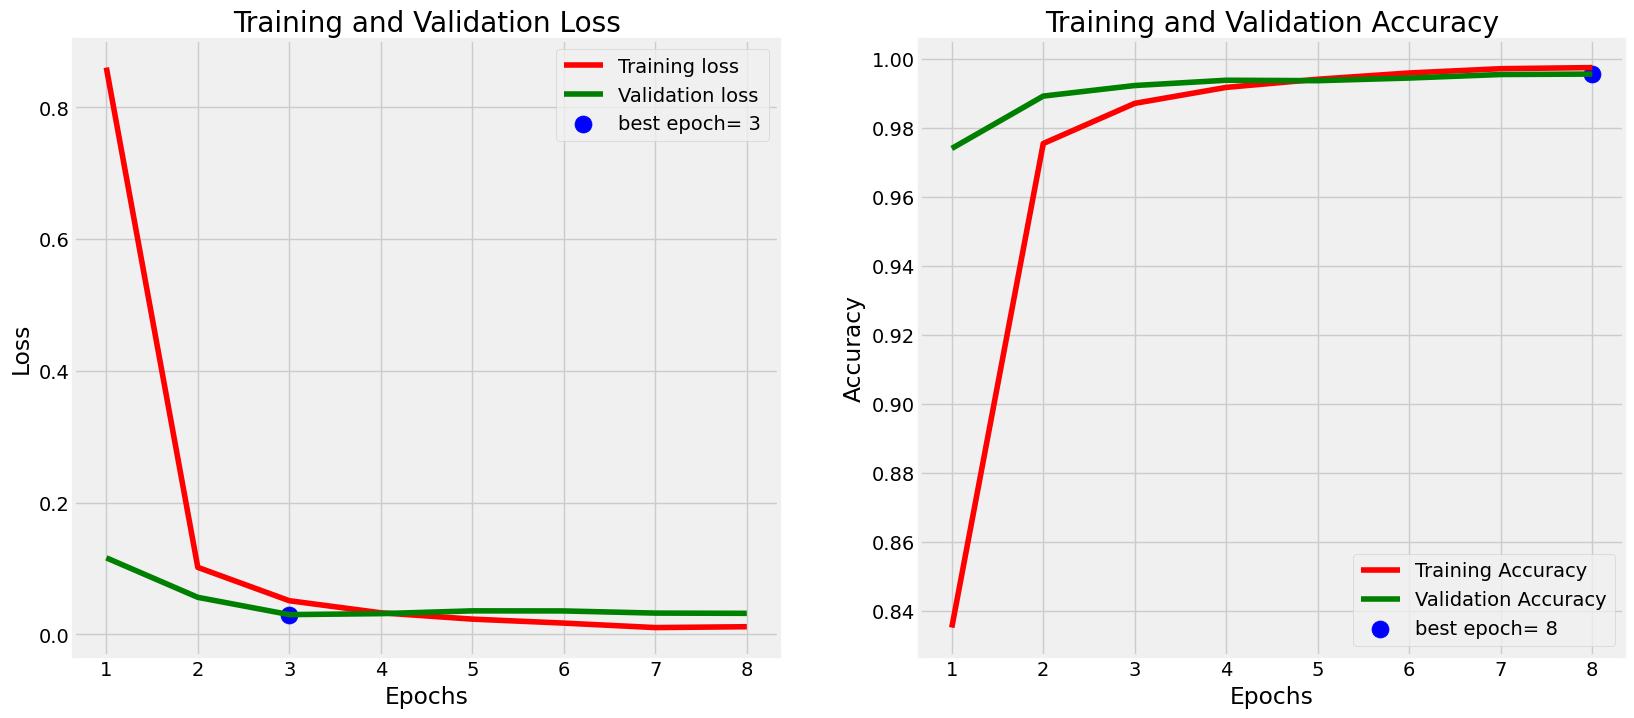

In [17]:
plot(history=history)

In [18]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

421/421 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9993 - loss: 0.0061
421/421 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9938 - loss: 0.0235


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


421/421 ━━━━━━━━━━━━━━━━━━━━ 34s 82ms/step - accuracy: 0.9620 - loss: 0.1740
Train Loss:  0.006400283891707659
Train Accuracy:  0.9991092681884766
--------------------
Valid Loss:  0.030272196978330612
Valid Accuracy:  0.992428719997406
--------------------
Test Loss:  0.18730758130550385
Test Accuracy:  0.9614014029502869


In [19]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

790/790 ━━━━━━━━━━━━━━━━━━━━ 37s 47ms/step


In [20]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        60
           1       0.93      0.98      0.96       720
          10       0.97      0.99      0.98       660
          11       0.90      0.99      0.94       420
          12       0.99      0.99      0.99       690
          13       0.99      0.99      0.99       720
          14       1.00      0.97      0.98       270
          15       0.94      0.97      0.96       210
          16       0.99      0.98      0.98       150
          17       1.00      0.99      0.99       360
          18       0.96      0.95      0.95       390
          19       1.00      1.00      1.00        60
           2       0.96      0.99      0.98       750
          20       0.85      0.99      0.91        90
          21       0.95      0.91      0.93        90
          22       0.93      0.93      0.93       120
          23       0.90      0.99      0.95       150
          24       0.97    